Импорт всех библиотек

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Загрузка данных и предворительный анализ

In [2]:
df = pd.read_csv('/Users/aleksandravdeev/Downloads/Telegram Desktop/Titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [4]:
print(df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


# Визуализация данных

/var/folders/ls/w7f7289x68jczrnbkg0rrj1c0000gn/T/ipykernel_18708/1320729485.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived', data=df, palette='Set2')


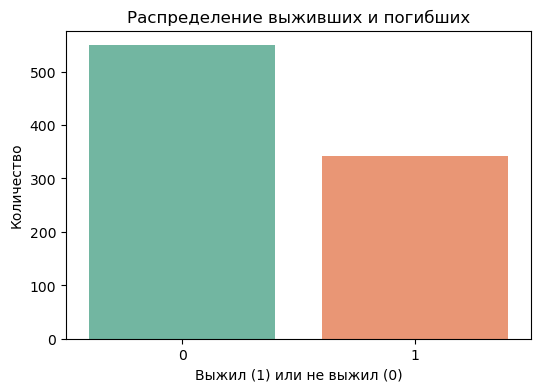

In [5]:
# Распределение выживших и погибших?
plt.figure(figsize=(6, 4))
sns.countplot(x='Survived', data=df, palette='Set2')
plt.title('Распределение выживших и погибших')
plt.xlabel('Выжил (1) или не выжил (0)')
plt.ylabel('Количество')
plt.show()
# Вывод: погибло гораздо больше людей нежели спаслось

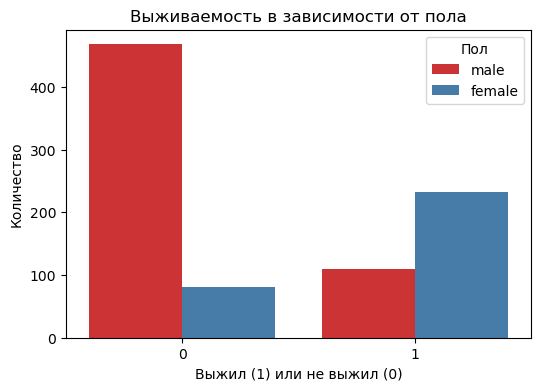

In [6]:
# Зависил ли пол человека на его шансы на выживание?
plt.figure(figsize=(6, 4))
sns.countplot(x='Survived', hue='Sex', data=df, palette='Set1')
plt.title('Выживаемость в зависимости от пола')
plt.xlabel('Выжил (1) или не выжил (0)')
plt.ylabel('Количество')
plt.legend(title='Пол')
plt.show()
# Вывод: у женщин шанс выжить были на порядок выше нежели у мужчин

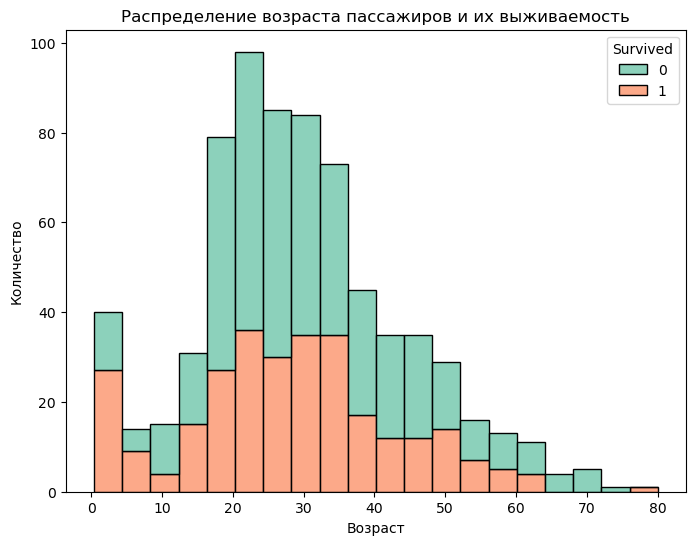

In [7]:
# Имел ли возраст наглядное значение при спасении людей?
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Age', hue='Survived', multiple='stack', palette='Set2', bins=20)
plt.title('Распределение возраста пассажиров и их выживаемость')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()
# Вывод: Судя по графику нельзя утверждать, что именно возраст повлиял на спасение тех или иных людей

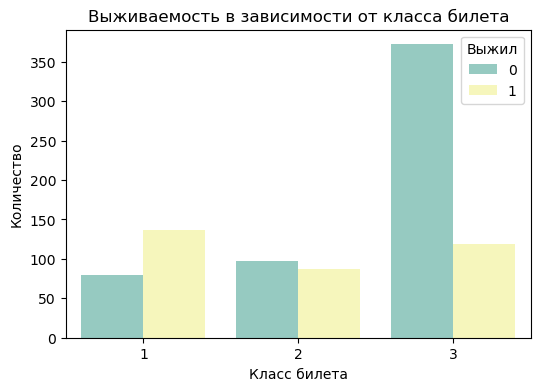

In [8]:
# Имел ли класс билета людей на шансы на выжывания?
plt.figure(figsize=(6, 4))
sns.countplot(x='Pclass', hue='Survived', data=df, palette='Set3')
plt.title('Выживаемость в зависимости от класса билета')
plt.xlabel('Класс билета')
plt.ylabel('Количество')
plt.legend(title='Выжил')
plt.show()
# Вывод: Да, чем более хорошим классом плыли люди, тем больше шансов выжить у них были

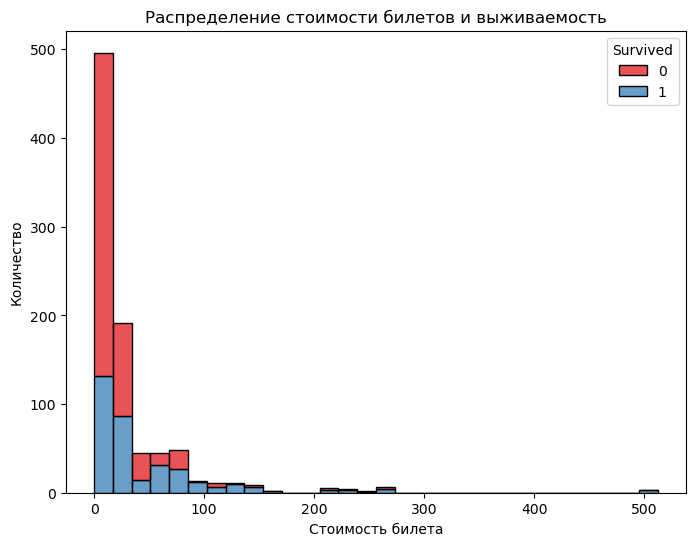

In [9]:
# Правда ли, что чем дороже стоил билет, тем выше шансы выжить были у людей?
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Fare', hue='Survived', multiple='stack', palette='Set1', bins=30)
plt.title('Распределение стоимости билетов и выживаемость')
plt.xlabel('Стоимость билета')
plt.ylabel('Количество')
plt.show()
# Да, у всех людей, что покупали билет по цене выше 100, шансы выжить были на порядок выше, чем у людей, которые покупали их дешевле

Обработка данных и создание новых признаков

In [10]:
# Заполнение пропущенных значений
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df['Cabin'].fillna('Unknown', inplace=True)

# Создание новых признаков
df['FamilySize'] = df['SibSp'] + df['Parch']
df['IsAlone'] = (df['FamilySize'] == 0).astype(int)

# Кодируем категориальные переменные (male/female, S/C/Q)
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Удаляем не нужные столбцы
df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

/var/folders/ls/w7f7289x68jczrnbkg0rrj1c0000gn/T/ipykernel_18708/3219706213.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/var/folders/ls/w7f7289x68jczrnbkg0rrj1c0000gn/T/ipykernel_18708/3219706213.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

Разделяем данные на признаки и целевую переменную

In [11]:
X = df.drop(columns=['Survived'])
y = df['Survived']

# Стандартизация данных
scaler = StandardScaler()
X = scaler.fit_transform(X)

Функция для создания модели

In [12]:
# Функция для создания модели
def create_model(input_shape, dropout_rate=0.5, neurons=128, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(input_shape,)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons//2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons//4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

Кросс-валидация и обучение модели

In [13]:
# Кросс-валидация
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_confusion_matrices = []

for train_index, test_index in kf.split(X):
    print(f"\nFold {fold}")
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index].values, y.iloc[test_index].values
    
    model = create_model(X_train.shape[1])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    class_weights = {0: 1, 1: 2}
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        class_weight=class_weights,
        verbose=1
    )
    
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    
    report = classification_report(y_test, y_pred)
    print(f"Classification Report for Fold {fold}:\n", report)
    
    matrix = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for Fold {fold}:\n", matrix)
    
    all_confusion_matrices.append(matrix)
    
    fold += 1

# Итоговая матрица ошибок
final_confusion_matrix = np.sum(all_confusion_matrices, axis=0)
print("\nFinal Confusion Matrix (summed across all folds):\n", final_confusion_matrix)

tn, fp, fn, tp = final_confusion_matrix.ravel()
print(f"Модель предсказала, что пассажир погибнет, но по факту выжил (False Positive) = {fp}")
print(f"Модель предсказала, что пассажир выживет, но по факту погиб (False Negative) = {fn}")
print(f"Модель предсказала, что пассажир выживет, и по факту выжил (True Positive) = {tp}")
print(f"Модель предсказала, что пассажир погибнет, и по факту погиб (True Negative) = {tn}")


Fold 1
Epoch 1/50


2025-02-24 16:19:31.029411: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


18/18 [==============================] - 0s 5ms/step - loss: 0.9316 - accuracy: 0.5571 - val_loss: 0.5992 - val_accuracy: 0.7413
Epoch 2/50
18/18 [==============================] - 0s 1ms/step - loss: 0.8538 - accuracy: 0.6801 - val_loss: 0.5230 - val_accuracy: 0.7902
Epoch 3/50
18/18 [==============================] - 0s 1ms/step - loss: 0.7988 - accuracy: 0.7030 - val_loss: 0.4714 - val_accuracy: 0.7902
Epoch 4/50
18/18 [==============================] - 0s 1ms/step - loss: 0.7751 - accuracy: 0.6995 - val_loss: 0.4325 - val_accuracy: 0.8252
Epoch 5/50
18/18 [==============================] - 0s 1ms/step - loss: 0.7667 - accuracy: 0.7153 - val_loss: 0.4194 - val_accuracy: 0.8322
Epoch 6/50
18/18 [==============================] - 0s 1ms/step - loss: 0.7254 - accuracy: 0.7487 - val_loss: 0.4079 - val_accuracy: 0.8392
Epoch 7/50
18/18 [==============================] - 0s 1ms/step - loss: 0.7506 - accuracy: 0.7346 - val_loss: 0.4126 - val_accuracy: 0.8322
Epoch 8/50
18/18 [=============

Вывод: Точность нейронной сети составила около 79%, этот результат сильно опережает случайное отгадывание, так что такой результат нас устраивает. Нейронная сеть могла бы сработать и лучше, будь база данных больше, для её идеальной раоты не хватает информации для обучения, поэтому на данном примере даты базы с задачей лучше бы справились алгоритмы: Random Forest и Градиентный бустинг.